<ipython-input-1-2428465846ae>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/ntu60models/WTMRNet_NTU_RGBD60.pth", map_location=dev

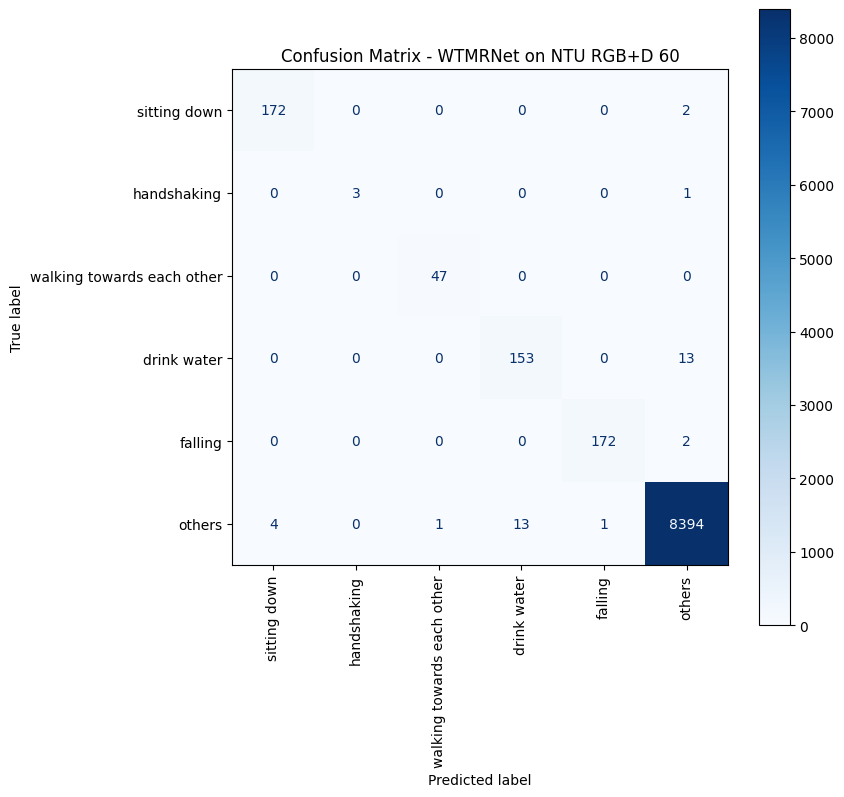

In [1]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

categories = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop", "pickup", "throw", "sitting down", 
    "standing up (from sitting position)", "clapping", "reading", "writing", "tear up paper", "wear jacket", "take off jacket", 
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on a hat/cap", "take off a hat/cap", "cheer up", 
    "hand waving", "kicking something", "reach into pocket", "hopping (one foot jumping)", "jump up", "make a phone call/answer phone", 
    "playing with phone/tablet", "typing on a keyboard", "pointing to something with finger", "taking a selfie", "check time (from watch)", 
    "rub two hands together", "nod head/bow", "shake head", "wipe face", "salute", "put the palms together", "cross hands in front (say stop)", 
    "sneeze/cough", "staggering", "falling", "touch head (headache)", "touch chest (stomachache/heart pain)", "touch back (backache)", 
    "touch neck (neckache)", "nausea or vomiting condition", "use a fan (with hand or paper)/feeling warm", "punching/slapping other person", 
    "kicking other person", "pushing other person", "pat on back of other person", "point finger at the other person", "hugging other person", 
    "giving something to other person", "touch other person's pocket", "handshaking", "walking towards each other", "walking apart from each other"
]

main_categories = [
    "sitting down", 
    "handshaking", 
    "walking towards each other", 
    "drink water", 
    "falling"
]
reduced_categories = main_categories + ["others"]

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

state_dict = torch.load("/kaggle/input/ntu60models/WTMRNet_NTU_RGBD60.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

category_map = {cat: (cat if cat in main_categories else "others") for cat in categories}

true_label_names = [categories[i] for i in true_labels]
pred_label_names = [categories[i] for i in pred_labels]

true_reduced_names = [category_map[name] for name in true_label_names]
pred_reduced_names = [category_map[name] for name in pred_label_names]

label_to_index = {label: i for i, label in enumerate(reduced_categories)}
true_encoded = [label_to_index[name] for name in true_reduced_names]
pred_encoded = [label_to_index[name] for name in pred_reduced_names]

cm = confusion_matrix(true_encoded, pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reduced_categories)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix - WTMRNet on NTU RGB+D 60")
plt.show()


In [2]:
!pip install --quiet ptflops thop

In [8]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=(1, 3), padding=(0, 1))
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=(1, 3), padding=(0, 1))

        self.pool = nn.MaxPool2d((1, 1))  
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, J, C = x.size()  

        x = x.view(B * T, J, C).permute(0, 2, 1).unsqueeze(-1) 

        x = self.relu(self.conv1(x))
        x = self.pool(x)  
        x = self.relu(self.conv2(x))
        x = self.pool(x)  

        x = x.view(B, T, J, -1) 
        return x  
class TimeSformer(nn.Module):
    def __init__(self, input_dim=128, num_joints=25, embed_dim=256, num_heads=8, depth=6, num_classes=60):
        super(TimeSformer, self).__init__()

        self.joint_embedding = nn.Linear(input_dim, embed_dim)  
        self.position_embedding = nn.Parameter(torch.zeros(1, num_joints * num_joints, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, num_joints * num_joints, embed_dim))

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, J, C = x.size()

        x = self.joint_embedding(x)  
        x = x + self.position_embedding[:, :J, :] 

        x = rearrange(x, 'b t j d -> b (t j) d')
        x = x + self.temporal_embedding[:, :x.shape[1], :]  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])
        x = self.head(x)
        return x
class WTMRNet(nn.Module):
    def __init__(self, num_classes=60):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)

    def forward(self, x):
        x = self.multi_region_cnn(x)  
        x = self.timesformer(x)  
        return x
        
model = WTMRNet(num_classes=60)
checkpoint = torch.load("/kaggle/input/ntu60models/WTMRNet_NTU_RGBD60.pth", map_location="cpu")

if "historyn" in checkpoint:
    del checkpoint["historyn"]

model = WTMRNet(num_classes=60)
model.load_state_dict(checkpoint)  
model.eval()


# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 25, 3)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 170
num_epochs = 40
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

<ipython-input-8-b2731e388257>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/ntu60models/WTMRNet_NTU_RGBD60.pth", map_location="cp

Model Parameters (Total): 4.81 M
GFLOPs (Multiply-Accumulate Ops): 1.92 GFLOPs
Average Inference Time per Clip: 0.0035 seconds
Throughput: 288.35 clips/second
Total Training Time: 1.89 hours


In [13]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer4(nn.Module):
    def __init__(self, input_dim=3, embed_dim=256, num_heads=8, depth=6, num_classes=60):
        super(TimeSformer4, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

        self.position_embedding = nn.Parameter(torch.randn(1, 400, embed_dim))  

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, J, C = x.size()  

        x = self.embedding(x)  
        x = rearrange(x, 'b t j d -> b (t j) d')  

        pos_embed = self.position_embedding[:, :x.shape[1], :]
        x = x + pos_embed

        cls_tokens = self.cls_token.expand(B, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1)  
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x      
        
model = TimeSformer4()
checkpoint = torch.load("/kaggle/input/ntu60models/TimeSformer4-NTU.pth", map_location="cpu")

if "history" in checkpoint:
    del checkpoint["history"]

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 25, 3)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 165
num_epochs = 30
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

<ipython-input-13-d6522a163884>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/ntu60models/TimeSformer4-NTU.pth", map_location="cpu

Model Parameters (Total): 4.75 M
GFLOPs (Multiply-Accumulate Ops): 1.90 GFLOPs
Average Inference Time per Clip: 0.0037 seconds
Throughput: 273.33 clips/second
Total Training Time: 1.38 hours


In [18]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN4(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_classes=60):
        super(MultiRegionCNN4, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=(1, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=(1, 3), padding=(0, 1))
        self.bn2 = nn.BatchNorm2d(hidden_dim * 2)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=(1, 3), padding=(0, 1))
        self.bn3 = nn.BatchNorm2d(hidden_dim * 4)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_dim * 4, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, J, C = x.size()  
        x = x.view(B * T, J, C).permute(0, 2, 1).unsqueeze(-1)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).view(B * T, -1)  
        
        x = self.fc(x)  
        x = x.view(B, T, -1).mean(dim=1) 
        return x      
        
model = MultiRegionCNN4()
checkpoint = torch.load("/kaggle/input/ntu60models/MultiRegionCNN4.pth", map_location="cpu")

if "historyn" in checkpoint:
    del checkpoint["historyn"]

model.load_state_dict(checkpoint)
model.eval()


# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 25, 3)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 64
num_epochs = 40
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

Model Parameters (Total): 0.14 M
GFLOPs (Multiply-Accumulate Ops): 0.05 GFLOPs
Average Inference Time per Clip: 0.0005 seconds
Throughput: 1927.97 clips/second
Total Training Time: 0.71 hours


<ipython-input-18-5fb1f20bf005>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/ntu60models/MultiRegionCNN4.pth", map_location="cpu"